In [141]:
# FETCH THE CSV DATA FROM THE API

from requests import get
import pandas as pd

base_url = "https://clinicaltrials.gov/api/query/study_fields?" # base url for our endpoint

expr = "solid tumor" # basic search term
actual_expr = expr.replace(' ', '+') # replace spaces in expr with '+'

fields = ["BriefTitle", "PrimaryOutcomeMeasure", "PrimaryOutcomeTimeFrame", "OverallStatus", "LastUpdatePostDate"] # fields we want to get
actual_fields = ",".join(fields) # join fields with commas

fmt = "csv" # get in csv format

num_results = 1000 # number of results we want – 1000 is maximum

params = {
    "expr": actual_expr,
    "fields": actual_fields,
    "min_rnk": "1",
    "max_rnk": str(num_results),
    "fmt": fmt
}

response = get(base_url, params=params)

if response.ok:
    print("Request successful!")
else:
    print("Request failed!")
print("\n\n" + response.text)

Request successful!


"APIVrs: 1.01.05"
"DataVrs: 2023:03:27 23:45:55.607"
"Expression: solid+tumor"
"NStudiesAvail: 446687"
"NStudiesFound: 13027"
"MinRank: 1"
"MaxRank: 1000"
"NStudiesReturned: 1000"
"Field Names: BriefTitle,PrimaryOutcomeMeasure,PrimaryOutcomeTimeFrame,OverallStatus,LastUpdatePostDate"

"Rank","BriefTitle","PrimaryOutcomeMeasure","PrimaryOutcomeTimeFrame","OverallStatus","LastUpdatePostDate"
1,"A Clinical Study on the Efficacy and Mechanism of Tumor Treatment Vaccine (TTV) for Recurrent and Refractory Advanced Solid Tumors","Relief degree of tumors","The last injection","Not yet recruiting","February 28, 2023"
2,"Solid Tumors in RASopathies","Prevalence of solid tumors in RASopathies","5 years","Recruiting","March 9, 2023"
3,"Genetic Investigation of Solid Tumors Cohort","Solid tumor biological insights","Study completion","Completed","June 12, 2014"
4,"Study on TIL for the Treatment of Advanced Solid Tumors","Adverse Events(AE)|Objective Response Rate (ORR)|Disease

In [142]:
# WRITE THE CSV DATA TO A FILE

import csv
lines = response.text.split('\n') # split by newlines

with open('output.csv', mode='w', newline='') as file: # open a file to write to
    writer = csv.writer(file, delimiter=';') # create a csv writer
    headers = ['Rank'] + fields # create headers
    writer.writerow(headers) # write headers

    for line in lines[11:]: # skip first 11 lines
        row = [txt for txt in line.split(',\"') if txt != ""] # split by commas followed by a quote, remove anything empty
        
        split_count = 0
        for i,text in enumerate(row):
            if split_count == 0 and row[i].count('|') >= 1: # if there are vertical bars
                split_count = row[i].count('|')+1 # count the number of copies of other fields we will need to make
            row[i] = text.replace('\"', '') # remove quotes
             
        if split_count: # we need to split by the primary outcome measures
            for i,text in enumerate(row):
                if row[i].count('|') >= 1:
                    row[i] = row[i].split('|') # split by vertical bars
                else:
                    row[i] = [row[i]]*split_count # make it a list
            # fetch each new row and write to file
            for r in zip(*row):
                writer.writerow(r)
        else:
            writer.writerow(row) # write row as it is
    print("File written successfully!")

File written successfully!


In [143]:
# READ INTO A PANDAS DATAFRAME
df = pd.read_csv("output.csv", delimiter=';')
df

,Rank,BriefTitle,PrimaryOutcomeMeasure,PrimaryOutcomeTimeFrame,OverallStatus,LastUpdatePostDate
0,1,A Clinical Study on the Efficacy and Mechanism...,Relief degree of tumors,The last injection,Not yet recruiting,"February 28, 2023"
1,2,Solid Tumors in RASopathies,Prevalence of solid tumors in RASopathies,5 years,Recruiting,"March 9, 2023"
2,3,Genetic Investigation of Solid Tumors Cohort,Solid tumor biological insights,Study completion,Completed,"June 12, 2014"
3,4,Study on TIL for the Treatment of Advanced Sol...,Adverse Events(AE),6 month,Recruiting,"December 21, 2022"
4,4,Study on TIL for the Treatment of Advanced Sol...,Objective Response Rate (ORR),Up to 36 months,Recruiting,"December 21, 2022"
...,...,...,...,...,...,...
2098,997,Talabostat and Pembrolizumab for the Treatment...,Dose limiting toxicity,At the end of Cycle 1 (each cycle is 21 days),"Active, not recruiting","March 15, 2023"
2099,998,Alvocidib in Treating Patients With Metastatic...,Dose-limiting toxicity (DLT),28 days,Terminated,"December 16, 2013"
2100,998,Alvocidib in Treating Patients With Metastatic...,"MTD (or recommended phase II dose), defined as...",28 days,Terminated,"December 16, 2013"
2101,999,A Phase 1 Protocol of 5-Azacytidine and Erloti...,Quality and quantity of adverse events due to ...,4 years,Completed,"May 1, 2013"


In [144]:
df.PrimaryOutcomeTimeFrame.value_counts()
# THIS IS GOING TO BE VERY TOUGH TO DEAL WITH...

2 years                                                                                                                                                  46
28 days                                                                                                                                                  40
Completed                                                                                                                                                33
12 months                                                                                                                                                27
3 years                                                                                                                                                  24
                                                                                                                                                         ..
From first dose of IO-108 until the end of treatment which is up

In [145]:
df.OverallStatus.value_counts()
# We probably should remove everything that is "Unknown Status" or random dates or other nonsense

Completed                  869
Recruiting                 568
Active, not recruiting     168
Terminated                 130
Not yet recruiting         102
Unknown status              80
Withdrawn                   21
Suspended                   12
July 2, 2017                 4
March 18, 2009               4
Enrolling by invitation      3
September 14, 2006           3
March 5, 2015                3
March 6, 2015                3
November 21, 2012            2
December 18, 2013            2
February 5, 2018             2
May 1, 2012                  2
November 29, 2019            2
May 1, 2013                  2
July 8, 2011                 2
April 14, 2011               2
January 13, 2014             2
May 20, 2008                 2
April 21, 2015               2
August 9, 2010               2
March 15, 2012               2
September 20, 2013           1
April 10, 2018               1
December 17, 2019            1
March 26, 2007               1
June 4, 2008                 1
October 

In [146]:
# Clean up by the overallstatus column
df = df[df['OverallStatus'].isin(['Completed', 'Terminated', 'Withdrawn', 'Active not recruiting', 'Recruiting', 'Enrolling by invitation', 'Suspended', 'Not yet recruiting'])]
df.OverallStatus.value_counts()
# So much better

Completed                  869
Recruiting                 568
Terminated                 130
Not yet recruiting         102
Withdrawn                   21
Suspended                   12
Enrolling by invitation      3
Name: OverallStatus, dtype: int64

<AxesSubplot:title={'center':'Number of studies by status'}, xlabel='Status', ylabel='Number of studies'>

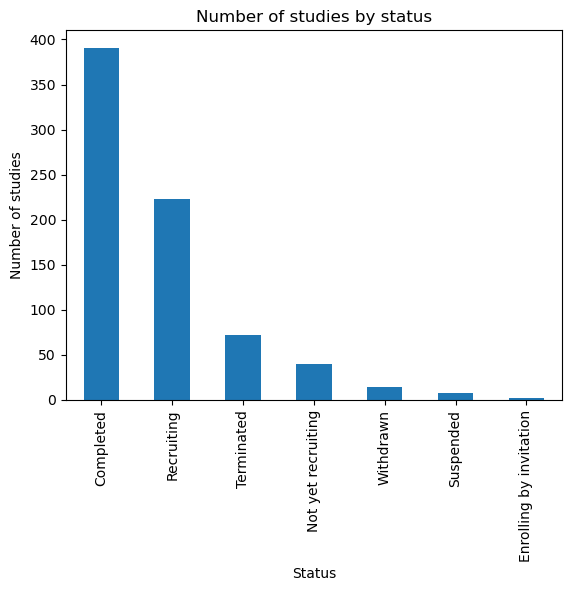

In [147]:
# Sample plot
per_study = df.drop_duplicates(subset='BriefTitle', keep='first') # remove duplicates from BriefTitle column to get a count of unique studies
per_study.OverallStatus.value_counts().plot(kind='bar', title='Number of studies by status', xlabel='Status', ylabel='Number of studies')

In [148]:
# CONVERT THE LastUpdatePostDate COLUMN TO A DATETIME
df['LastUpdatePostDate'] = pd.to_datetime(df['LastUpdatePostDate'])
df

/var/folders/f1/87whmjt97m90gfstrm2p61d80000gn/T/ipykernel_2279/638955077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LastUpdatePostDate'] = pd.to_datetime(df['LastUpdatePostDate'])


,Rank,BriefTitle,PrimaryOutcomeMeasure,PrimaryOutcomeTimeFrame,OverallStatus,LastUpdatePostDate
0,1,A Clinical Study on the Efficacy and Mechanism...,Relief degree of tumors,The last injection,Not yet recruiting,2023-02-28
1,2,Solid Tumors in RASopathies,Prevalence of solid tumors in RASopathies,5 years,Recruiting,2023-03-09
2,3,Genetic Investigation of Solid Tumors Cohort,Solid tumor biological insights,Study completion,Completed,2014-06-12
3,4,Study on TIL for the Treatment of Advanced Sol...,Adverse Events(AE),6 month,Recruiting,2022-12-21
4,4,Study on TIL for the Treatment of Advanced Sol...,Objective Response Rate (ORR),Up to 36 months,Recruiting,2022-12-21
...,...,...,...,...,...,...
2096,996,A Study of MEDI5395 in Combination With Durval...,Number of Participants With at Least 1-Grade S...,From first dose of MEDI5395 through 14.4 month...,Completed,2023-02-21
2099,998,Alvocidib in Treating Patients With Metastatic...,Dose-limiting toxicity (DLT),28 days,Terminated,2013-12-16
2100,998,Alvocidib in Treating Patients With Metastatic...,"MTD (or recommended phase II dose), defined as...",28 days,Terminated,2013-12-16
2101,999,A Phase 1 Protocol of 5-Azacytidine and Erloti...,Quality and quantity of adverse events due to ...,4 years,Completed,2013-05-01
